<a href="https://colab.research.google.com/github/snufkin92/colab_tutorial/blob/master/section_12/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 転移学習の実装
巨大な画像データセット「ImageNet」により学習済みのモデルに、全結合層を追加します。  
学習済みのモデルは訓練せずに、新たに追加した層のみを訓練して画像の分類を行います。  



## 各設定
tensorflowとKerasのバージョンによっては、Kerasのコードでエラーが発生することがあります。エラーを回避するために、以下のセルでKerasのバージョンを指定してインストールします。  
以下のコードは、デフォルトのバージョンでエラーが発生しないときには必要ありません。

In [3]:
# !pip install keras==2.3  # 2020/3/28の時点ではtensorflow2.Xに対応するために必要
!pip install keras==2.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: Keras 2.3.0
    Uninstalling Keras-2.3.0:
      Successfully uninstalled Keras-2.3.0


なお、Googleの対応により上記のコードは近いうちに必要なくなるかと思います。  
今後tensorflowやKerasのバージョンアップにより同様の問題が発生する可能性がありますが、上記のようにしてバージョンを調整することによる対応が必要になります。  
上記のセルの実行後、**ランタイム→ランタイムを再起動**によりバージョンの更新が完了します。  
念のために、以下のコードによりバージョンを確認しておきましょう。

In [4]:
import tensorflow
import keras
print(tensorflow.__version__)
print(keras.__version__)

2.15.0
2.15.0


必要なモジュールのインポート、最適化アルゴリズムの設定、及び各定数の設定を行います。  
今回はCIFAR-10の分類を行うので、画像の幅と高さは32、チャンネル数は3に設定します。

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam

optimizer = Adam()

img_size = 64  # 画像の幅と高さ
n_channel = 3  # チャンネル数
n_mid = 256  # 中間層のニューロン数

batch_size = 32
epochs = 20

## VGG16の導入
ImageNetを使って訓練済みのモデル、VGG16をkeras.applicationsから導入します。  
今回はこのモデルを特徴の抽出のために使用しますが、追加の訓練は行いません。  
https://keras.io/ja/applications/#vgg16

In [17]:
from keras.applications import VGG16

model_vgg16 = VGG16(weights="imagenet",  # ImageNetで学習したパラメータを使用
                 include_top=False,  # 全結合層を含まない
                 input_shape=(img_size, img_size, n_channel))  # 入力の形状
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

## CIFAR-10
Kerasを使い、CIFAR-10を読み込みます。  
今回はこのうち飛行機と自動車の画像のみ使い、画像が飛行機か自動車かを判定できるように新たに追加した層を訓練します。  
以下のコードでは、CIFAR-10を読み込み、ランダムな25枚の画像を表示します。  
元の画像サイズは32×32なのですが、VGG16の入力は48x48以上のサイズである必要があるため、NumPyのrepeat関数によりサイズを2倍に調整します。  


CIFAR10のラベルは以下の通り

    ラベル「0」： airplane（飛行機）
    ラベル「1」： automobile（自動車）
    ラベル「2」： bird（鳥）
    ラベル「3」： cat（猫）
    ラベル「4」： deer（鹿）
    ラベル「5」： dog（犬）
    ラベル「6」： frog（カエル）
    ラベル「7」： horse（馬）
    ラベル「8」： ship（船）
    ラベル「9」： truck（トラック）

Original size: (10000, 32, 32, 3)
Input size: (10000, 64, 64, 3)


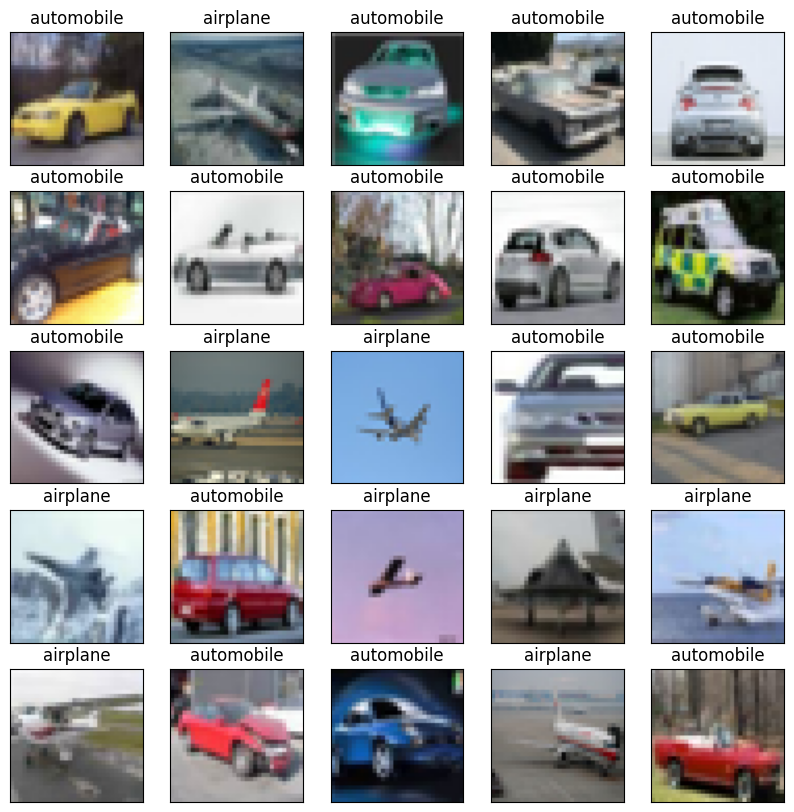

In [18]:
from keras.datasets import cifar10

(x_train, t_train), (x_test, t_test) = cifar10.load_data()

# １次元に変換
t_train = t_train.reshape(-1)
t_test = t_test.reshape(-1)

# ラベルが0と1のデータのみ取り出す
x_train = x_train[t_train <= 1]
t_train = t_train[t_train <= 1]
x_test = x_test[t_test <= 1]
t_test = t_test[t_test <= 1]

print("Original size:", x_train.shape)

# 画像を拡大（高さ、幅をそれぞれ２倍に拡大）
x_train = x_train.repeat(2, axis=1).repeat(2, axis=2)
x_test = x_test.repeat(2, axis=1).repeat(2, axis=2)

print("Input size:", x_train.shape)

n_image = 25
rand_idx = np.random.randint(0, len(x_train), n_image)
cifar10_labels = np.array(["airplane", "automobile"])
plt.figure(figsize=(10,10))  # 画像の表示サイズ
for i in range(n_image):
    cifar_img=plt.subplot(5,5,i+1)
    plt.imshow(x_train[rand_idx[i]])
    label = cifar10_labels[t_train[rand_idx[i]]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルと目盛りを非表示に

## モデルの構築
導入したVGG16に全結合層を追加します。  
訓練するのは追加した全結合層のみで、VGG16の層は訓練しません。  


In [19]:
model = Sequential()
model.add(model_vgg16)

model.add(Flatten())  # 一次元の配列に変換
model.add(Dense(n_mid))
model.add(Activation("relu"))
model.add(Dropout(0.5))  # ドロップアウト
model.add(Dense(1))
model.add(Activation("sigmoid"))

model_vgg16.trainable = False  # 訓練済みの層は訓練しない

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
 activation_1 (Activation)   (None, 1)                

## 学習
モデルを訓練します。  
過学習を防ぐために、データ拡張を導入します。  
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターでGPUを選択しましょう。  

In [20]:
from keras.preprocessing.image import ImageDataGenerator

x_train = x_train / 255  # 0から1の範囲に収める
x_test = x_test / 255

# データ拡張
generator = ImageDataGenerator(
           rotation_range=0.2,
           width_shift_range=0.2,
           height_shift_range=0.2,
           shear_range=10,
           zoom_range=0.2,
           horizontal_flip=True)
generator.fit(x_train)

# 訓練
history = model.fit_generator(generator.flow(x_train, t_train, batch_size=batch_size),
                              epochs=epochs,
                              validation_data=(x_test, t_test))

Epoch 1/20


<ipython-input-20-ddefa2aa8007>:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator.flow(x_train, t_train, batch_size=batch_size),


313/313 [==============================] - 27s 66ms/step - loss: 0.2774 - accuracy: 0.8834 - val_loss: 0.1978 - val_accuracy: 0.9225
Epoch 2/20
313/313 [==============================] - 20s 65ms/step - loss: 0.2104 - accuracy: 0.9162 - val_loss: 0.1609 - val_accuracy: 0.9385
Epoch 3/20
313/313 [==============================] - 19s 62ms/step - loss: 0.1968 - accuracy: 0.9210 - val_loss: 0.1736 - val_accuracy: 0.9320
Epoch 4/20
313/313 [==============================] - 20s 64ms/step - loss: 0.1872 - accuracy: 0.9249 - val_loss: 0.1438 - val_accuracy: 0.9480
Epoch 5/20
313/313 [==============================] - 20s 64ms/step - loss: 0.1795 - accuracy: 0.9283 - val_loss: 0.1540 - val_accuracy: 0.9410
Epoch 6/20
313/313 [==============================] - 20s 64ms/step - loss: 0.1767 - accuracy: 0.9286 - val_loss: 0.1433 - val_accuracy: 0.9445
Epoch 7/20
313/313 [==============================] - 19s 60ms/step - loss: 0.1727 - accuracy: 0.9316 - val_loss: 0.1370 - val_accuracy: 0.9475
Epo

## 学習の推移
historyを使って、学習の推移を確認します。

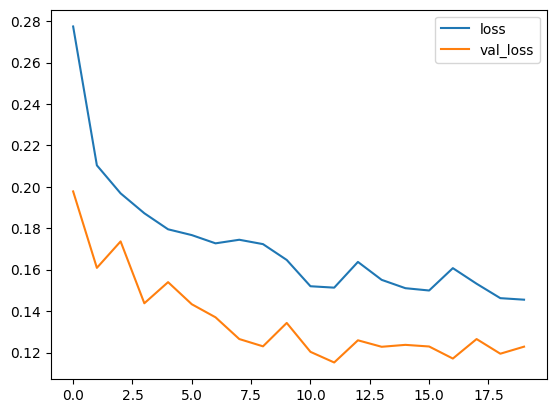

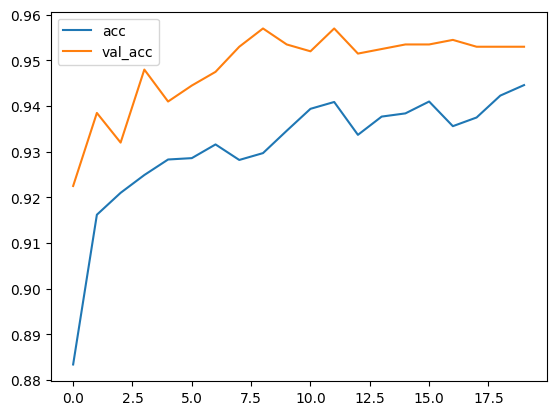

In [21]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']  # 訓練用データの誤差
train_acc = history.history['accuracy']  # 訓練用データの精度
val_loss = history.history['val_loss']  # 検証用データの誤差
val_acc = history.history['val_accuracy']  # 検証用データの精度

plt.plot(np.arange(len(train_loss)), train_loss, label='loss')
plt.plot(np.arange(len(val_loss)), val_loss, label='val_loss')
plt.legend()
plt.show()

plt.plot(np.arange(len(train_acc)), train_acc, label='acc')
plt.plot(np.arange(len(val_acc)), val_acc, label='val_acc')
plt.legend()
plt.show()

訓練済みのモデルを特徴の抽出に用いることで、追加した全結合層を訓練するのみでも画像の分類が可能であることが確認できました。